In [1]:
import torch
import torch.autograd.functional as F
import torch.distributions as dist

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import ipywidgets as widgets


import seaborn as sns

import pandas as pd
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())
#plt.rcParams.update(bundles.icml2022())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [3]:
import hamiltorch

In [4]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

In [6]:
gt_distribution = torch.distributions.Normal(0, 1)

# Samples from the ground truth distribution
def sample_gt(n):
    return gt_distribution.sample((n,))

samples = sample_gt(1000)

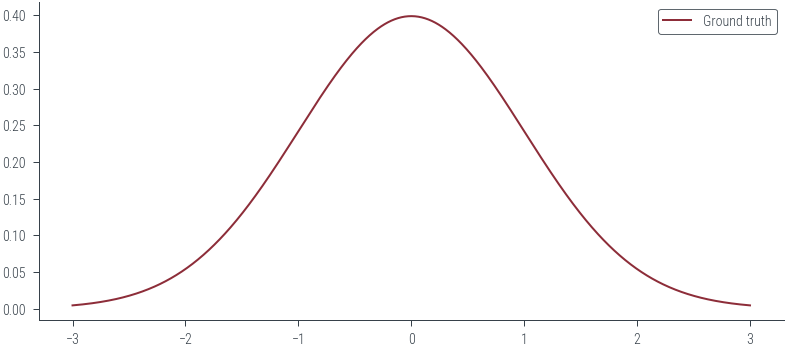

In [7]:
x_lin = torch.linspace(-3, 3, 1000)
y_lin = torch.exp(gt_distribution.log_prob(x_lin))

plt.plot(x_lin, y_lin, label='Ground truth')
plt.legend()

In [8]:
# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return gt_distribution.log_prob(x)

In [9]:
logprob(torch.tensor([0.0]))

tensor([-0.9189])

In [10]:
# Markov chain
x_start = torch.tensor([0.0])
samples = []
for i in range(100):
    prop = torch.distributions.Normal(x_start, 10).sample()
    samples.append(prop)
    x_start = prop



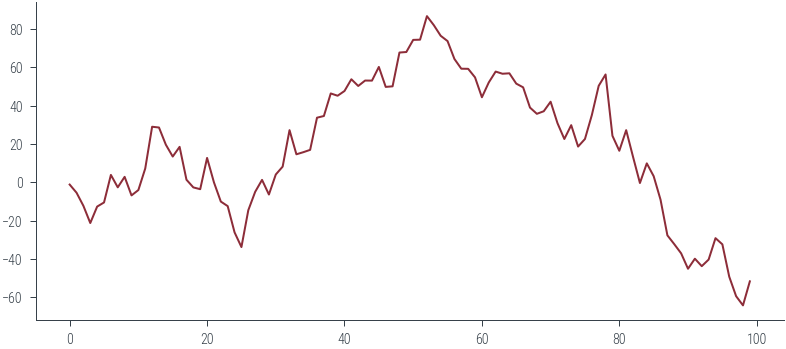

In [11]:
plt.plot(torch.stack(samples).ravel())

In [12]:
# Initial state
x0 = torch.tensor([0.0])
num_samples = 5000
step_size = 0.3
num_steps_per_sample = 5
hamiltorch.set_random_seed(123)

In [13]:
params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,  
                               num_samples=num_samples, step_size=step_size, 
                               num_steps_per_sample=num_steps_per_sample)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:07 | 0d:00:00:00 | #################### | 5000/5000 | 686.98       
Acceptance Rate 0.99


In [14]:
params_hmc = torch.tensor(params_hmc)

In [15]:
def run_hmc(logprob, x0, num_samples, step_size, num_steps_per_sample):
    torch.manual_seed(123)
    params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,
                                    num_samples=num_samples, step_size=step_size,
                                    num_steps_per_sample=num_steps_per_sample)
    return torch.stack(params_hmc)


params_hmc = run_hmc(logprob, x0, num_samples, step_size, num_steps_per_sample)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:07 | 0d:00:00:00 | #################### | 5000/5000 | 676.50       
Acceptance Rate 0.99


In [25]:
params_hmc.shape

torch.Size([5000, 1])

Text(0, 0.5, 'Parameter value')

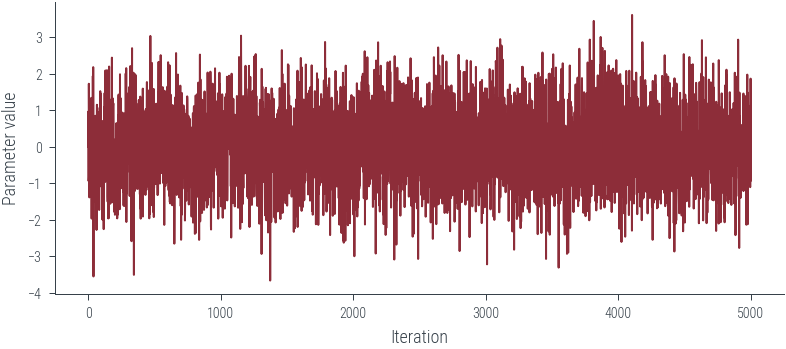

In [26]:
# Trace plot
plt.plot(params_hmc, label='Trace')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')

Text(0, 0.5, 'Parameter value')

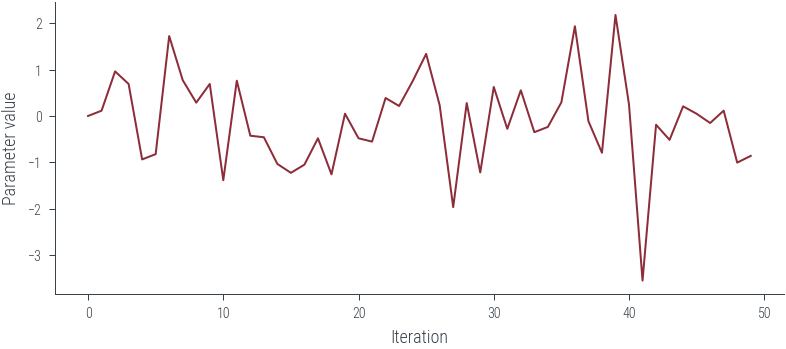

In [28]:
# view first 500 samples
plt.plot(params_hmc[:50], label='Trace')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')


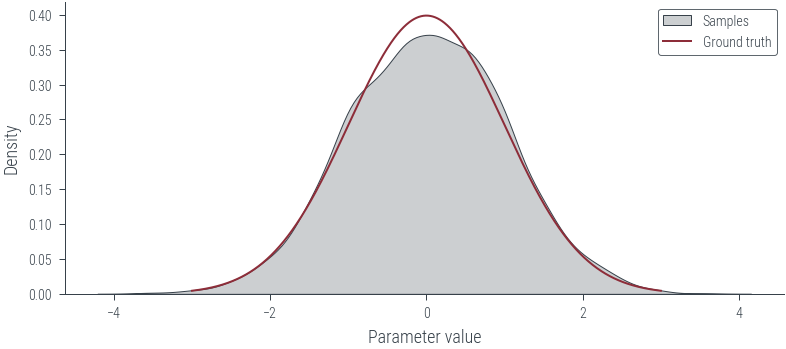

In [29]:
# KDE plot
import seaborn as sns
plt.figure()
sns.kdeplot(params_hmc.ravel().detach().numpy(), label='Samples', shade=True, color='C1')
plt.plot(x_lin, y_lin, label='Ground truth')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.legend()

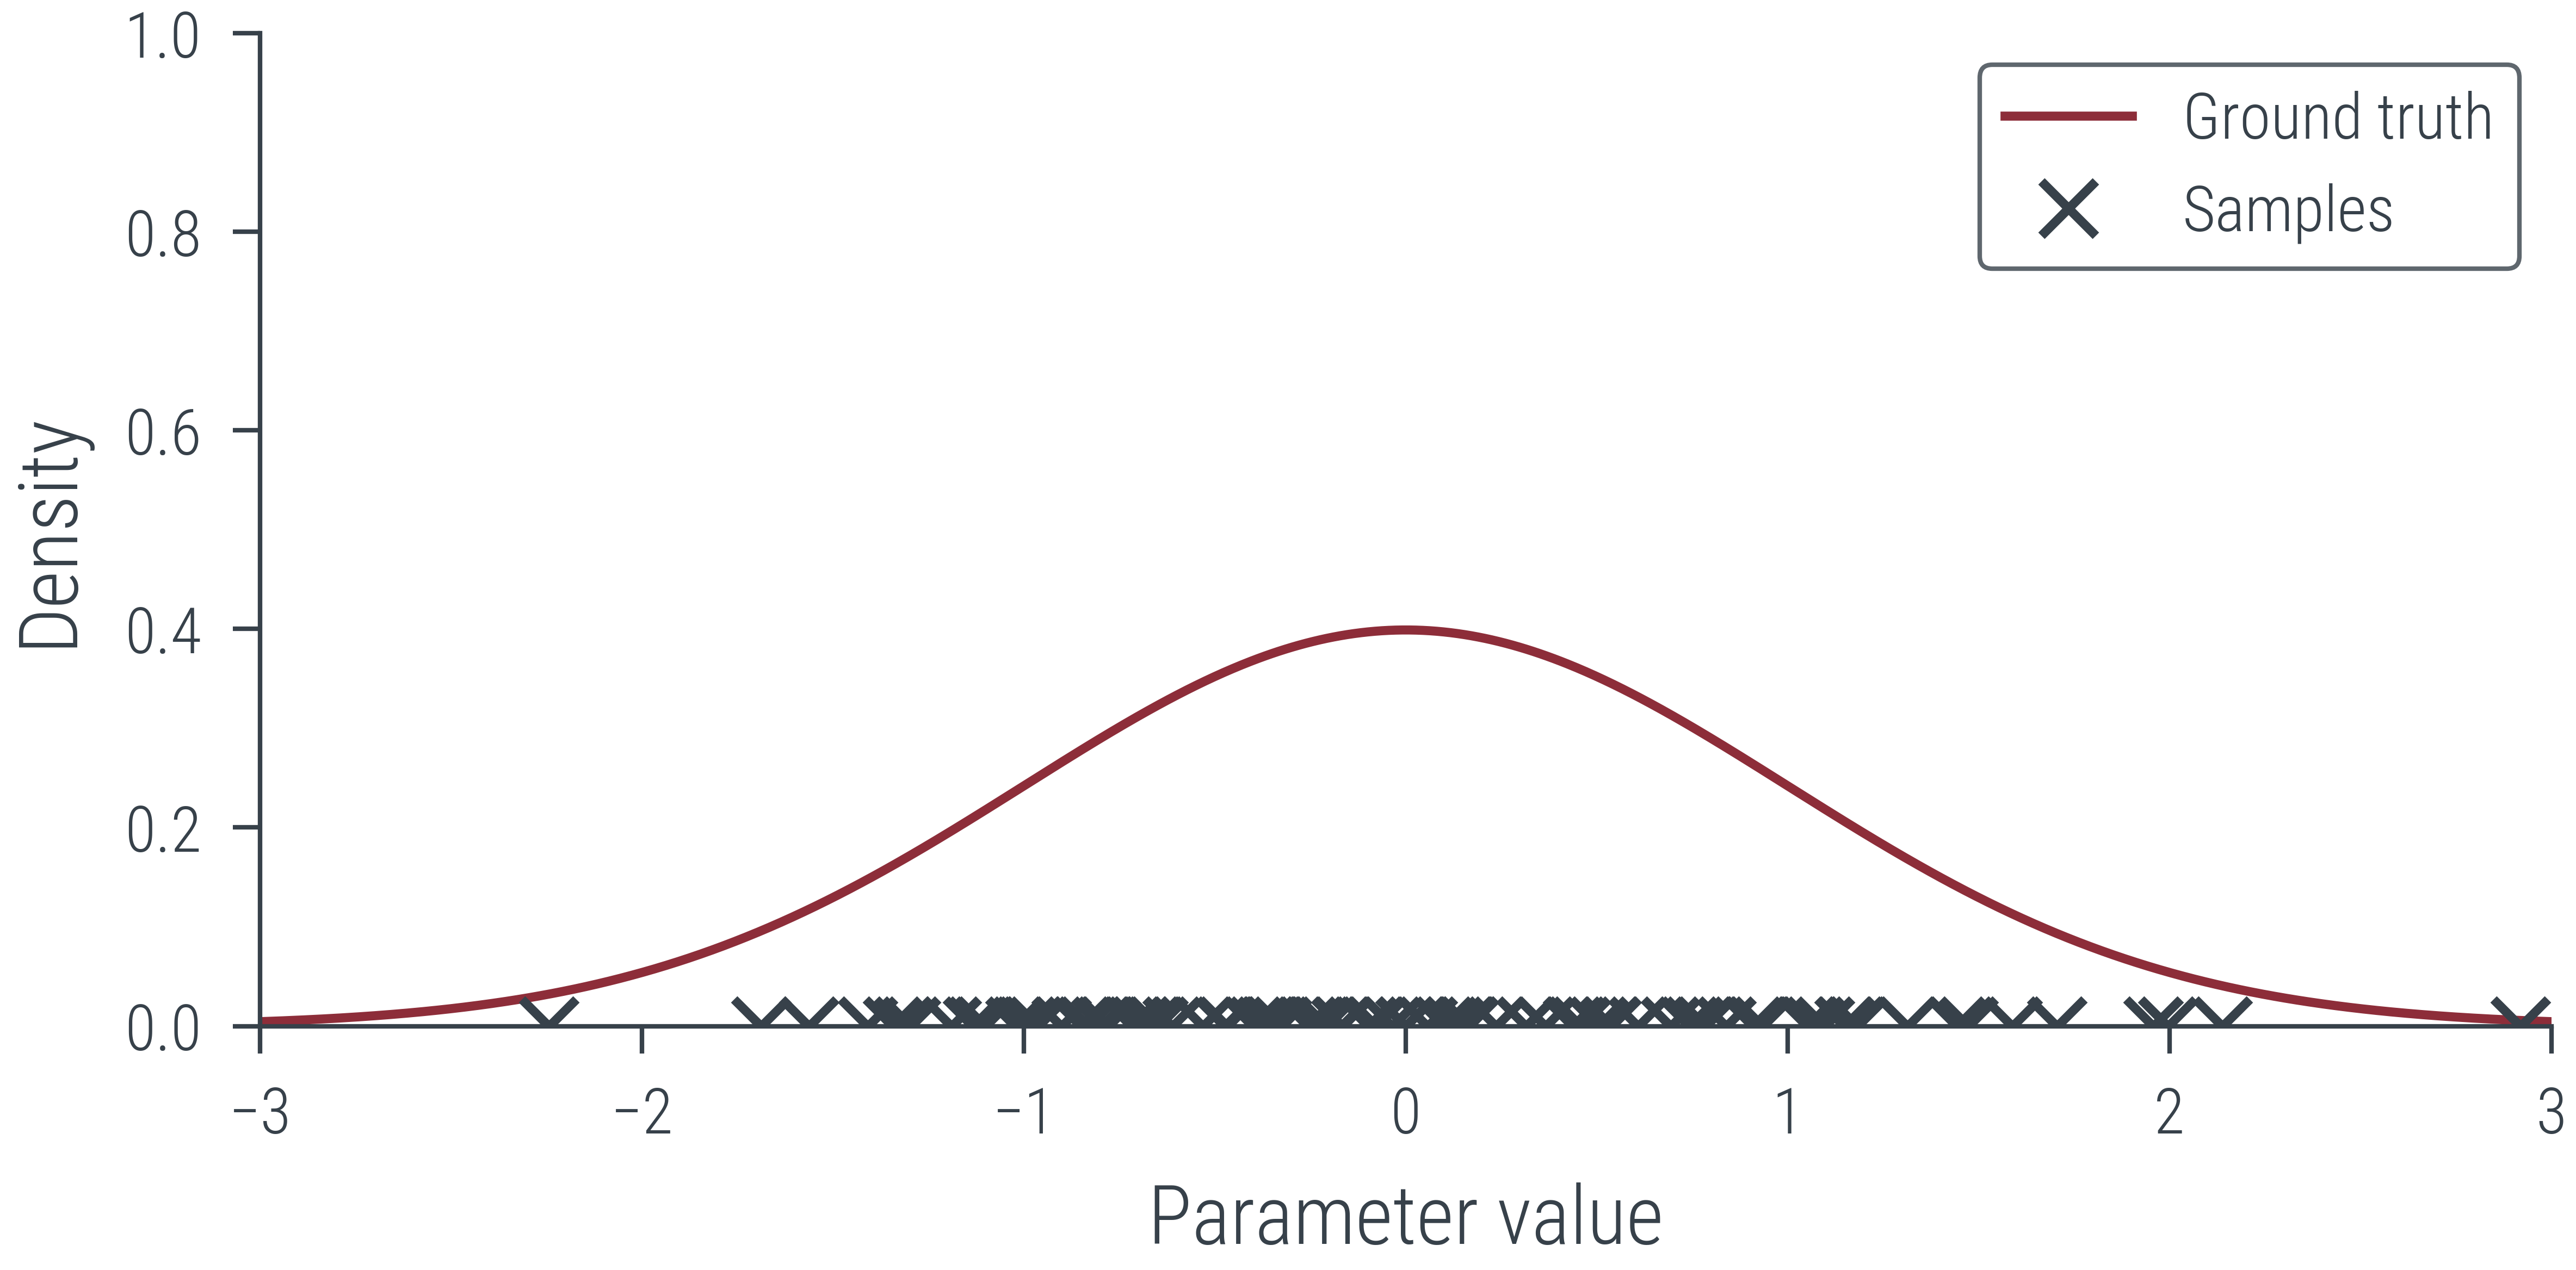

In [19]:
# Create MP4 HTML5 video showing sampling process

def create_mp4_samples(samples, x_lin, y_lin, filename='samples.mp4', dpi=600):
    fig, ax = plt.subplots(figsize=(4,2), dpi=dpi)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Parameter value')
    ax.set_ylabel('Density')
    ax.plot(x_lin, y_lin, label='Ground truth')
    ax.legend()

    # Add a "x" marker to the plot for each sample at y=0
    x_marker, = ax.plot([], [], 'x', color='C1', label='Samples')
    ax.legend()

    def init():
        x_marker.set_data([], [])
        return x_marker,

    def animate(i):
        x_marker.set_data(samples[:i], torch.zeros(i))
        return x_marker,

    anim = FuncAnimation(fig, animate, init_func=init,
                                     frames=len(samples), interval=20, blit=True)
    anim.save(filename, dpi=dpi, writer='ffmpeg')

create_mp4_samples(params_hmc[:100], x_lin, y_lin, filename='../figures/sampling/mcmc/normal.mp4', dpi=600)

In [68]:
from IPython.display import Video
Video('../figures/sampling/mcmc/normal.mp4', width=400)

<AxesSubplot:ylabel='Density'>

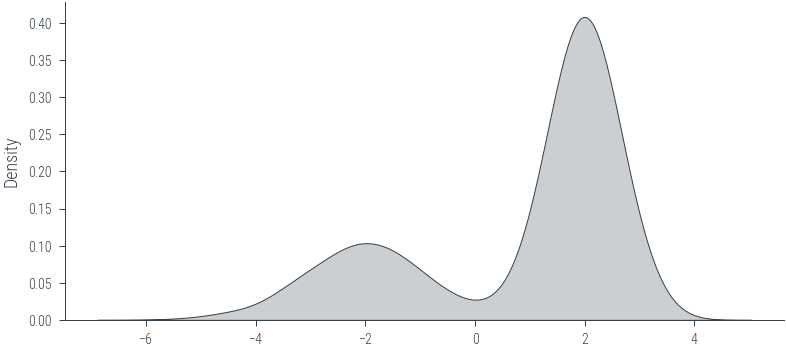

In [30]:
# sample from Mixture of Gaussians

mog = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(torch.tensor([0.3, 0.7])),
    component_distribution=dist.Normal(torch.tensor([-2.0, 2.0]), torch.tensor([1.0, 0.5]))
)

samples = mog.sample((1000,))
sns.kdeplot(samples.numpy(), label='Samples', shade=True, color='C1')

In [31]:
# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return mog.log_prob(x)

logprob(torch.tensor([0.0]))

tensor([-4.1114])

In [32]:
params_hmc = run_hmc(logprob, x0, num_samples, step_size, num_steps_per_sample)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 459.19       
Acceptance Rate 0.99


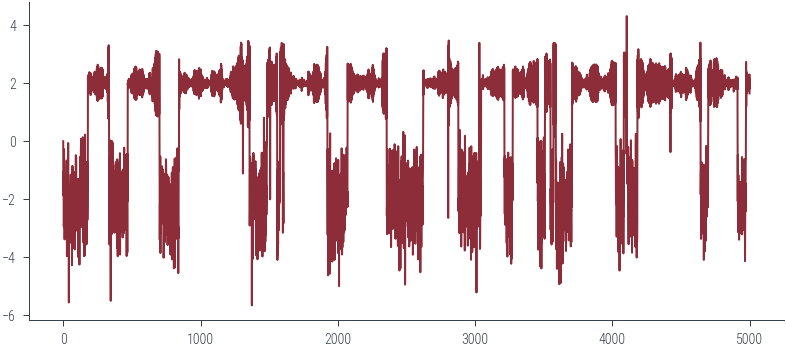

In [33]:
# Trace plot
plt.plot(params_hmc, label='Trace')

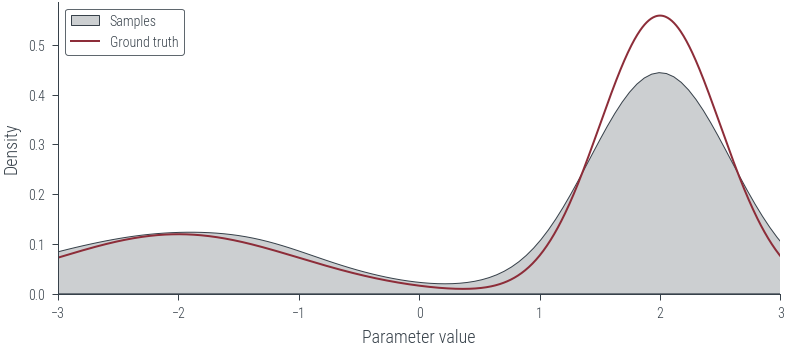

In [34]:
y_lin = torch.exp(mog.log_prob(x_lin))


# KDE plot
plt.figure()
sns.kdeplot(params_hmc.ravel().detach().numpy(), label='Samples', shade=True, color='C1')
# Limit KDE plot to range of ground truth
plt.xlim(-3, 3)
plt.plot(x_lin, y_lin, label='Ground truth')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.legend()

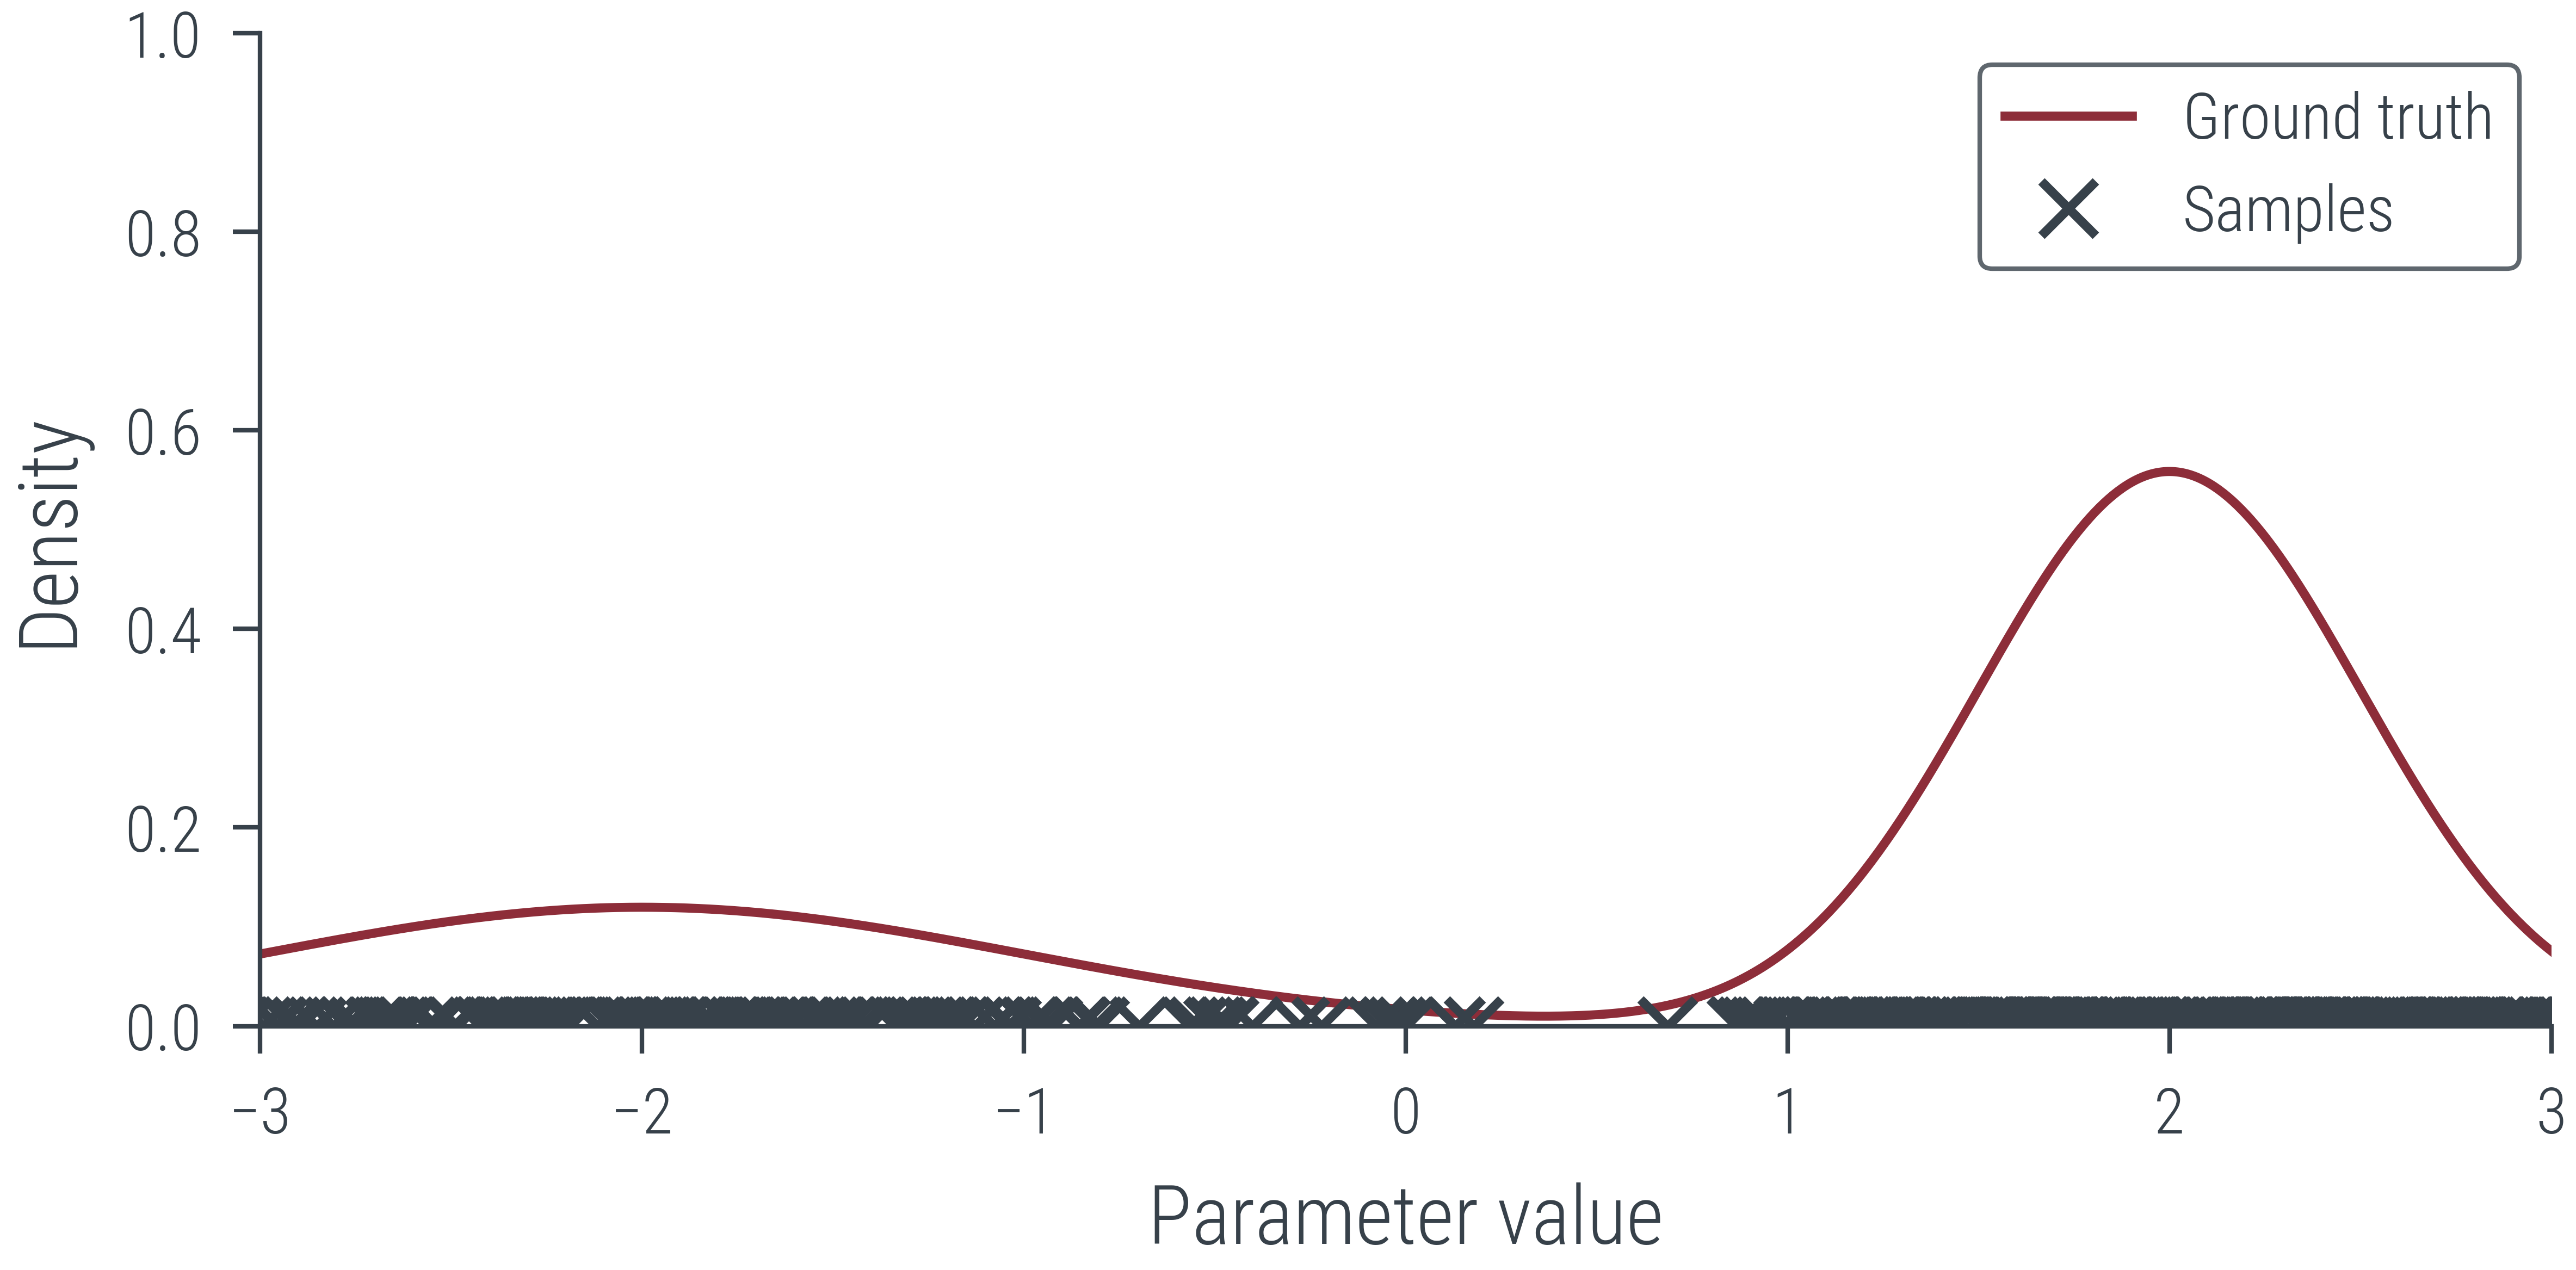

In [66]:
# Create MP4 HTML5 video showing sampling process
create_mp4_samples(params_hmc[:500], x_lin, y_lin, filename='../figures/sampling/mcmc/mog.mp4', dpi=600)

In [69]:
Video('../figures/sampling/mcmc/mog.mp4', width=400)

### Sampling from an unnormalized distribution

In [35]:
def p_tilde(x):
    # normalising constant for standard normal distribution
    Z = torch.sqrt(torch.tensor(2*np.pi))
    return dist.Normal(0, 1).log_prob(x).exp()*Z

def p_tilde_log_prob(x):
    # normalising constant for standard normal distribution
    Z = torch.sqrt(torch.tensor(2*np.pi))
    return dist.Normal(0, 1).log_prob(x) + torch.log(Z)

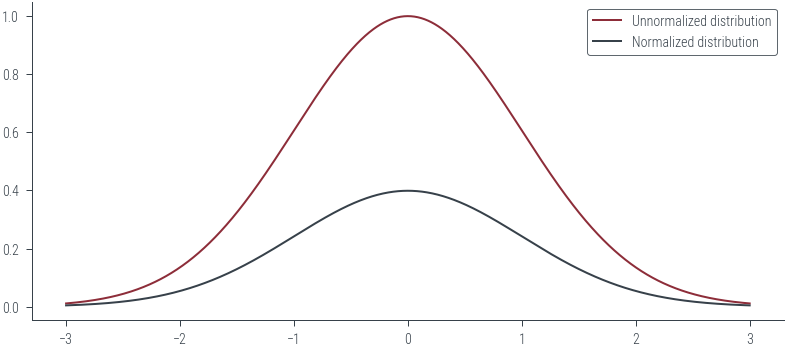

In [36]:
# Plot unnormalized distribution
x_lin = torch.linspace(-3, 3, 1000)
y_lin = p_tilde(x_lin)
plt.plot(x_lin, y_lin, label='Unnormalized distribution')
# Plot normalized distribution
plt.plot(x_lin, dist.Normal(0, 1).log_prob(x_lin).exp(), label='Normalized distribution')
plt.legend()

In [37]:
# HMC over unnormalized distribution

# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return p_tilde_log_prob(x)

In [38]:
# HMC
params_hmc = run_hmc(logprob, x0, num_samples, step_size, num_steps_per_sample)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 479.28       
Acceptance Rate 0.99


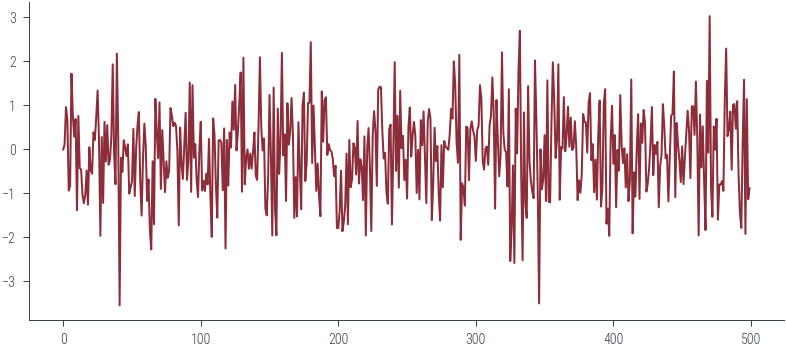

In [39]:
# Trace plot
plt.plot(params_hmc[:500], label='Trace')

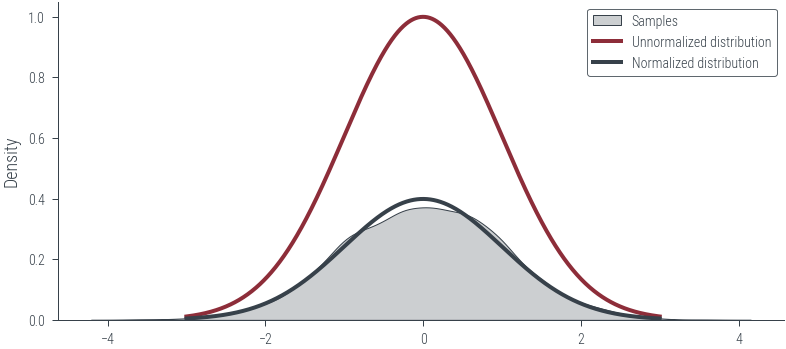

In [40]:
# KDE plot
sns.kdeplot(params_hmc.ravel().detach().numpy(), label='Samples', shade=True, color='C1')
plt.plot(x_lin, y_lin, label='Unnormalized distribution', lw=2)
plt.plot(x_lin, dist.Normal(0, 1).log_prob(x_lin).exp(), label='Normalized distribution', lw=2)
plt.legend()

### Coin Toss

#### Working with probabilities

In [42]:
prior = dist.Beta(1, 1)
data = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0])
n = len(data)

def log_prior(theta):
    return prior.log_prob(theta)

def log_likelihood(theta):
    return dist.Bernoulli(theta).log_prob(data).sum()

def log_joint(theta):
    return log_prior(theta) + log_likelihood(theta)

In [43]:
try:
    params_hmc_theta = run_hmc(log_joint, torch.tensor([0.5]), 5000, 0.3, 5)
except Exception as e:
    print(e)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Expected value argument (Tensor of shape (1,)) to be within the support (Interval(lower_bound=0.0, upper_bound=1.0)) of the distribution Beta(), but found invalid values:
tensor([-0.1017], requires_grad=True)


#### Working with logits

In [44]:
# Let us work instead with logits
def log_prior(logits):
    return prior.log_prob(torch.sigmoid(logits)).sum()

def log_likelihood(logits):
    return dist.Bernoulli(logits=logits).log_prob(data).sum()

def log_joint(logits):
    return (log_prior(logits) + log_likelihood(logits))

In [45]:
params_hmc_logits = run_hmc(log_joint, torch.tensor([0.0]), 1000, 0.3, 5)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 275.76       
Acceptance Rate 0.99


Text(0.5, 0, 'Iteration')

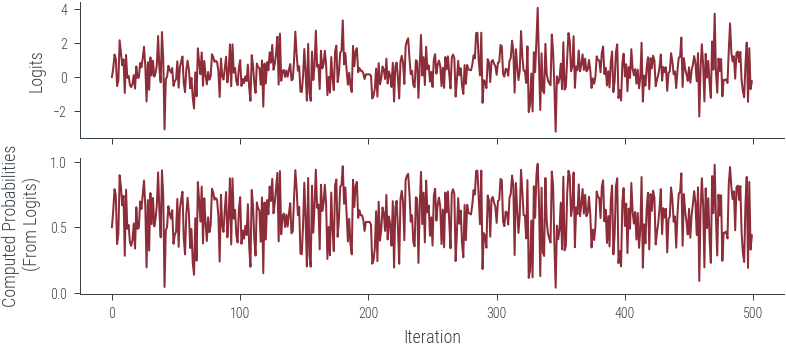

In [46]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(params_hmc_logits[:500], label='Trace for logits')
ax[1].plot(torch.sigmoid(params_hmc_logits[:500]), label='Trace for probabilities')
ax[0].set_ylabel('Logits')
ax[1].set_ylabel('Computed Probabilities\n (From Logits)')
ax[1].set_xlabel('Iteration')

In [49]:
# Create a function to update the KDE plot with the specified bw_adjust value
def update_kde_plot(bw_adjust):
    plt.clf()  # Clear the previous plot
    plt.hist(torch.sigmoid(params_hmc_logits[:, 0]).detach().numpy(), bins=100, density=True, label='Samples (Histogram)', color='C2', alpha=0.5, lw=1)
    sns.kdeplot(torch.sigmoid(params_hmc_logits[:, 0]).detach().numpy(), label='Samples (KDE)', shade=False, color='C1', clip=(0, 1), bw_adjust=bw_adjust, lw=2)
    x_lin = torch.linspace(0, 1, 1000)
    y_lin = dist.Beta(1+3, 1+2).log_prob(x_lin).exp()
    plt.plot(x_lin, y_lin, label='True posterior')
    plt.legend()

# Create the slider widget for bw_adjust
bw_adjust_slider = widgets.FloatSlider(value=0.1, min=0.01, max=4.0, step=0.01, description='bw_adjust:')

# Create the interactive plot
interactive_plot = widgets.interactive(update_kde_plot, bw_adjust=bw_adjust_slider)

# Display the interactive plot
display(interactive_plot)

interactive(children=(FloatSlider(value=0.1, description='bw_adjust:', max=4.0, min=0.01, step=0.01), Output()…

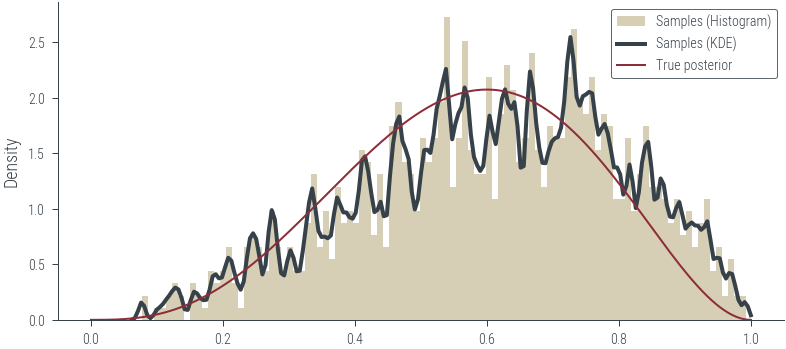

In [94]:
# Plot histogram of samples
plt.hist(torch.sigmoid(params_hmc_logits[:, 0]).detach().numpy(), bins=100, density=True, label='Samples (Histogram)', color='C2', alpha=0.5, lw=1 )

# Plot posterior KDE using seaborn but clip to [0, 1]
sns.kdeplot(torch.sigmoid(params_hmc_logits[:, 0]).detach().numpy(), label='Samples (KDE)', shade=False, color='C1', clip=(0, 1), bw_adjust=0.1, lw=2)
# True posterior
x_lin = torch.linspace(0, 1, 1000)
y_lin = dist.Beta(1+3, 1+2).log_prob(x_lin).exp()
plt.plot(x_lin, y_lin, label='True posterior')
plt.legend()

Text(0, 0.5, 'y')

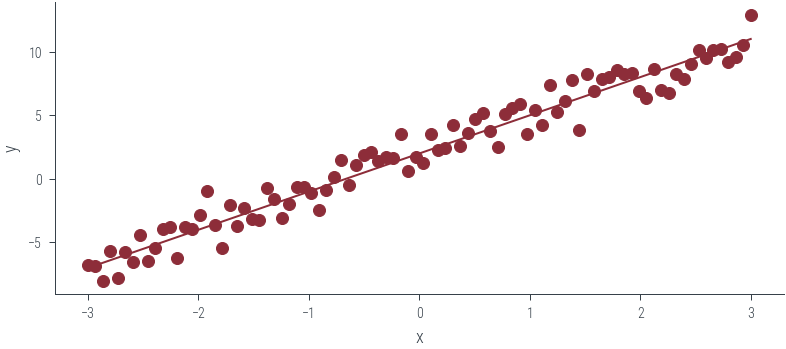

In [16]:
# Linear regression for 1 dimensional input using HMC

x_lin = torch.linspace(-3, 3, 90)
theta_0_true = torch.tensor([2.0])
theta_1_true = torch.tensor([3.0])
f = lambda x: theta_0_true + theta_1_true * x
eps = torch.randn_like(x_lin) *1.0
y_lin = f(x_lin) + eps

plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth')
plt.xlabel('x')
plt.ylabel('y')

In [51]:
# Esimate theta_0, theta_1 using HMC assuming noise variance is known to be 1
def logprob(theta):
    y_pred = theta[0] + x_lin * theta[1]
    return dist.Normal(y_pred, 1).log_prob(y_lin).sum()

def log_prior(theta):
    return dist.Normal(0, 1).log_prob(theta).sum()

def log_posterior(theta):
    return logprob(theta) + log_prior(theta)

In [52]:
params_hmc_lin_reg = run_hmc(log_posterior, torch.tensor([0.0, 0.0]), 1000, 0.05, 10)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:06 | 0d:00:00:00 | #################### | 1000/1000 | 157.83       
Acceptance Rate 0.95


In [20]:
params_hmc_lin_reg

tensor([[0.0000, 0.0000],
        [1.8463, 1.5993],
        [2.1721, 3.8480],
        ...,
        [1.9128, 2.9478],
        [2.1689, 2.9928],
        [1.8748, 3.0217]])

In [57]:
lps = []
for p in params_hmc_lin_reg:
    lps.append(log_posterior(p))


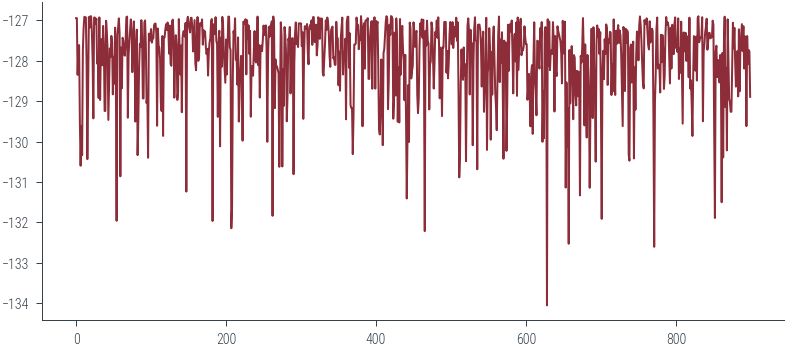

In [61]:
plt.plot(torch.stack(lps).ravel()[100:])

In [55]:
log_posterior(params_hmc_lin_reg[0]), log_posterior(params_hmc_lin_reg[1]), log_posterior(params_hmc_lin_reg[2])

(tensor(-1554.2708), tensor(-392.7923), tensor(-242.6276))

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


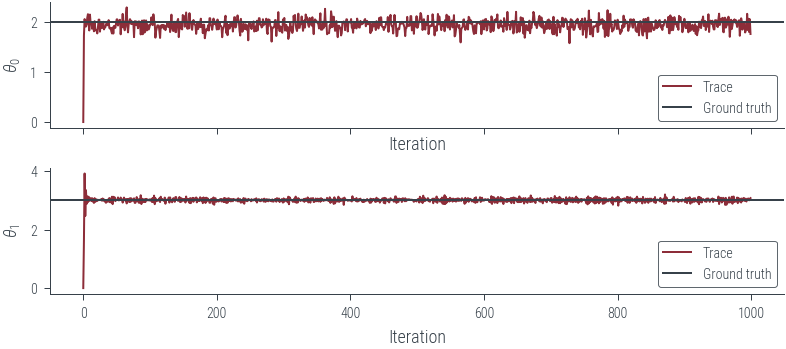

In [62]:
# Plot the traces corresponding to the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc_lin_reg.T):
    axes[i].plot(param_vals, label='Trace')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true]):
    axes[i].axhline(param_vals.numpy(), color='C1', label='Ground truth')
    axes[i].legend()

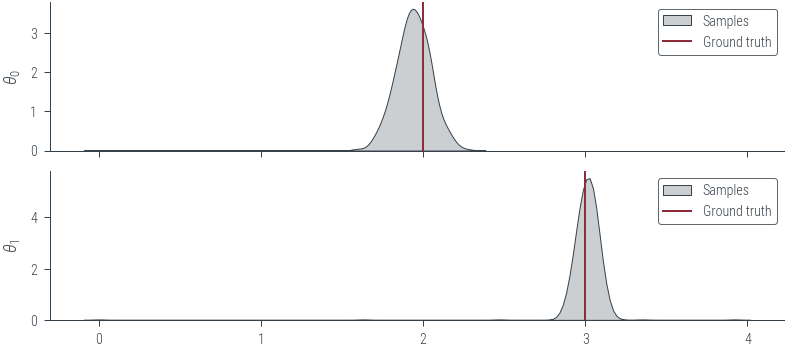

In [63]:
# Plot KDE of the samples for the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc_lin_reg.T):
    sns.kdeplot(param_vals.detach().numpy(), label='Samples', shade=True, color='C1', ax=axes[i])
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true]):
    axes[i].axvline(param_vals.numpy(), color='C0', label='Ground truth')
    axes[i].legend()

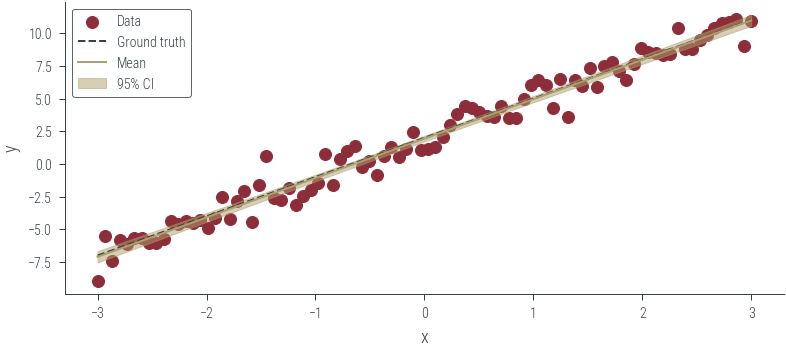

In [64]:
# Plot the posterior predictive distribution
plt.figure()
plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth', color='C1', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')

# Get posterior samples. Thin first 100 samples to remove burn-in
posterior_samples = params_hmc_lin_reg[100:].detach()
y_hat = posterior_samples[:, 0].unsqueeze(1) + x_lin * posterior_samples[:, 1].unsqueeze(1)

# Plot mean and 95% confidence interval

plt.plot(x_lin, y_hat.mean(axis=0), label='Mean', color='C2')
plt.fill_between(x_lin, y_hat.mean(axis=0) - 2 * y_hat.std(axis=0), y_hat.mean(axis=0) + 2 * y_hat.std(axis=0), alpha=0.5, label='95% CI', color='C2')
plt.legend()

In [74]:
# Using a neural network with HMC

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x

In [75]:
net = Net()
net

Net(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
)

In [76]:
net.state_dict()

OrderedDict([('fc1.weight', tensor([[0.7689]])),
             ('fc1.bias', tensor([0.2034]))])

In [77]:
hamiltorch.util.flatten(net)

tensor([0.7689, 0.2034], grad_fn=<CatBackward0>)

In [78]:
theta_params = hamiltorch.util.flatten(net) + 1.0
theta_params

tensor([1.7689, 1.2034], grad_fn=<AddBackward0>)

In [80]:
from nn_manual_hmc import log_joint as log_joint_nn

In [81]:
params_hmc = run_hmc(log_joint_nn, torch.tensor([0.2, 0.5]), 1000, 0.05, 5)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 1000/1000 | 202.36       
Acceptance Rate 0.94


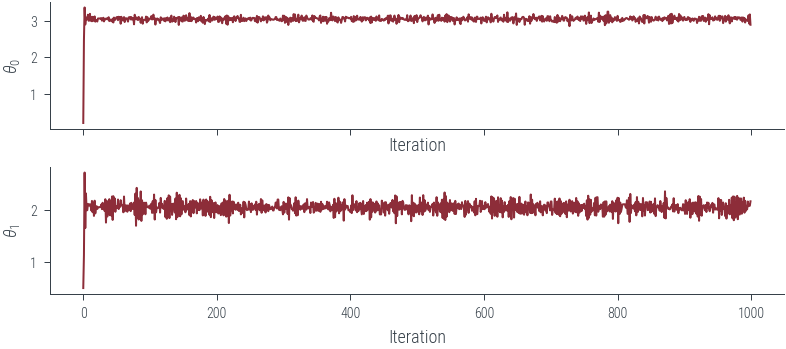

In [82]:
# Plot the traces corresponding to the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    axes[i].plot(param_vals, label='Trace')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(fr'$\theta_{i}$')

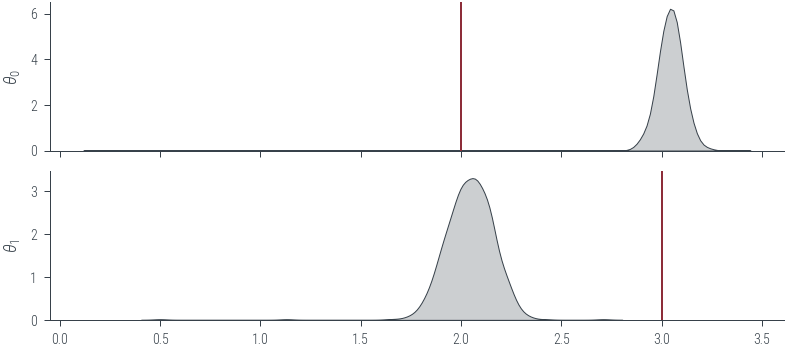

In [83]:
# Plot KDE of the samples for the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    sns.kdeplot(param_vals.detach().numpy(), label='Samples', shade=True, color='C1', ax=axes[i])
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Mark the true values
axes[0].axvline(theta_0_true.numpy(), color='C0', label='Ground truth')
axes[1].axvline(theta_1_true.numpy(), color='C0', label='Ground truth')


In [84]:
# Get posterior samples. Thin first 100 samples to remove burn-in
posterior_samples = params_hmc.detach()
y_preds = []
with torch.no_grad():
    for theta in posterior_samples:
        params_list = hamiltorch.util.unflatten(net, theta)
        params = net.state_dict()
        for i, (name, _) in enumerate(params.items()):
            params[name] = params_list[i]
        y_pred = torch.func.functional_call(net, params, x_lin.unsqueeze(1)).squeeze()

        y_preds.append(y_pred)


In [85]:
torch.stack(y_preds).shape

torch.Size([1000, 90])

Text(0, 0.5, 'y')

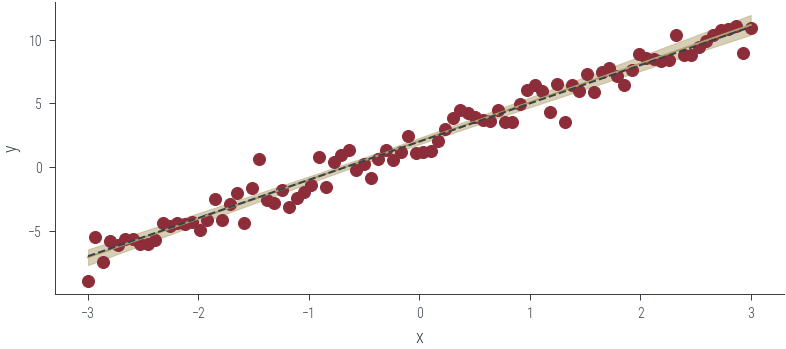

In [86]:
y_mean = torch.stack(y_preds).mean(axis=0)
y_std = torch.stack(y_preds).std(axis=0)

plt.plot(x_lin, y_mean, label='Mean', color='C2')
plt.fill_between(x_lin, y_mean - 2 * y_std, y_mean + 2 * y_std, alpha=0.5, label='95% CI', color='C2')

plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth', color='C1', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')



In [66]:
step_size = 0.0005
num_samples = 1000
L = 30
burn = -1
store_on_GPU = False
debug = False
model_loss = 'regression'
mass = 1.0

# Effect of tau
# Set to tau = 1000. to see a function that is less bendy (weights restricted to small bends)
# Set to tau = 1. for more flexible

tau = 1.0 # Prior Precision
tau_out = 110.4439498986428 # Output Precision
r = 0 # Random seed


tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list)

# Set initial weights
params_init = hamiltorch.util.flatten(net).clone()
# Set the Inverse of the Mass matrix
inv_mass = torch.ones(params_init.shape) / mass



In [69]:
integrator = hamiltorch.Integrator.EXPLICIT
sampler = hamiltorch.Sampler.HMC

hamiltorch.set_random_seed(r)
params_hmc_f = hamiltorch.sample_model(net, x_lin.view(-1, 1), y_lin.view(-1, 1), params_init=params_init,
                                       model_loss=model_loss, num_samples=100,
                                       burn = burn, inv_mass=inv_mass,step_size=step_size,
                                       num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list,
                                       debug=debug, store_on_GPU=store_on_GPU,
                                       sampler = sampler)

# At the moment, params_hmc_f is on the CPU so we move to GPU

params_hmc_gpu = [ll for ll in params_hmc_f[1:]]




Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 100/100 | 49.73       
Acceptance Rate 1.00


In [70]:
torch.stack(params_hmc_gpu).shape

torch.Size([100, 2])

In [71]:
# Let's predict over the entire test range [-2,2]
pred_list, log_probs_f = hamiltorch.predict_model(net, x = x_lin.view(-1, 1), y = y_lin.view(-1, 1), samples=params_hmc_gpu,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

In [72]:
pred_list.shape

torch.Size([100, 90, 1])

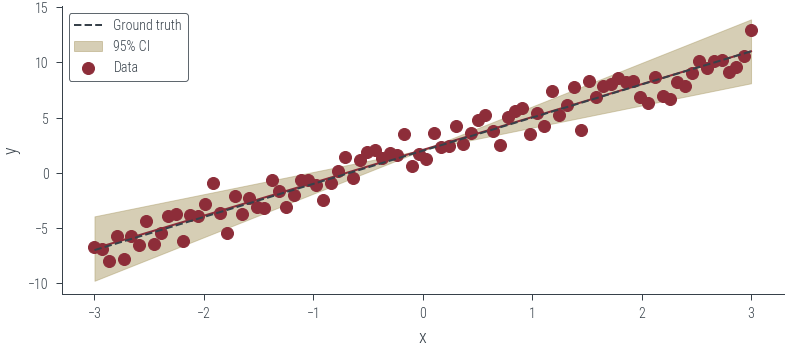

In [77]:
plt.plot(x_lin, pred_list.mean(axis=0).ravel())
# Plot the true function
plt.plot(x_lin, f(x_lin), label='Ground truth', color='C1', linestyle='--')

# Plot standard deviation
plt.fill_between(x_lin, pred_list.mean(axis=0).ravel() - 2 * pred_list.std(axis=0).ravel(), pred_list.mean(axis=0).ravel() + 2 * pred_list.std(axis=0).ravel(), alpha=0.5, label='95% CI', color='C2')

plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [17]:
from nn_manual_hmc_classification import log_joint, x_moon, y_moon, net_classification


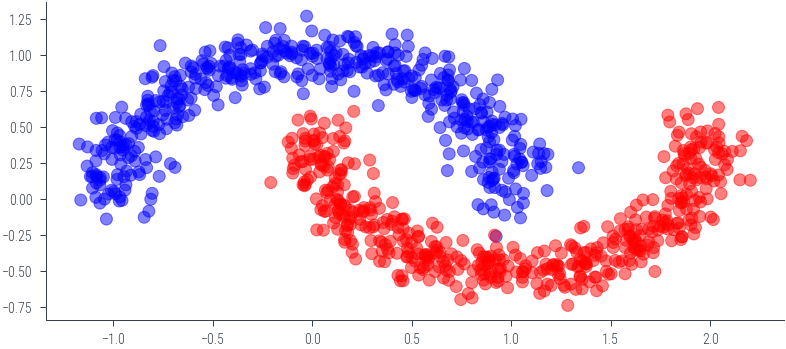

In [18]:
plt.scatter(x_moon[:, 0].cpu().numpy(), x_moon[:, 1].cpu().numpy(), c=y_moon.cpu().numpy(), cmap='bwr', alpha=0.5)

In [19]:
net_classification

Net_Classification(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
hamiltorch.util.flatten(net_classification).shape

torch.Size([51])

In [22]:
# number of params in the network
D = hamiltorch.util.flatten(net_classification).shape[0]

In [23]:
log_joint(torch.zeros(D).to(device))

tensor(-740.0131, device='cuda:0')

In [24]:
params_hmc = run_hmc(log_joint, torch.tensor(torch.zeros(D).to(device)), 2000, 0.01, 2)

Sampling (Sampler.HMC; Integrator.IMPLICIT)


/tmp/ipykernel_948360/3753994728.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params_hmc = run_hmc(log_joint, torch.tensor(torch.zeros(D).to(device)), 2000, 0.01, 2)


Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:21 | 0d:00:00:00 | #################### | 2000/2000 | 93.82       
Acceptance Rate 0.96


In [25]:
params_hmc.shape

torch.Size([2000, 51])

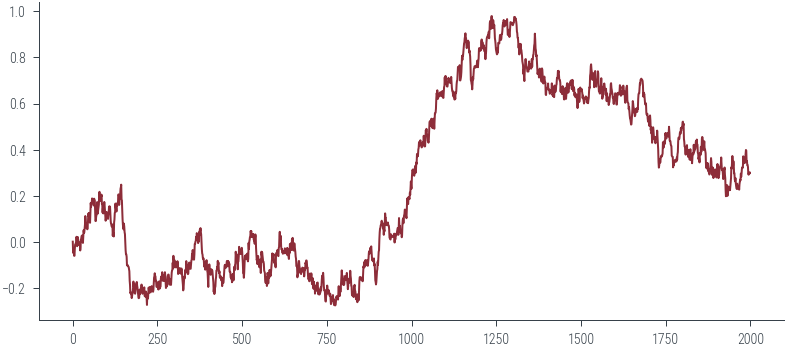

In [26]:
plt.plot(params_hmc[:, 2].cpu().numpy())

In [34]:
# Get posterior predictive over the 2D grid
posterior_samples = params_hmc.detach()
# Consider burning the first 100 samples
posterior_samples = posterior_samples[1000:]
y_preds = []
n_grid = 200
lims = 4
twod_grid = torch.tensor(np.meshgrid(np.linspace(-lims, lims, n_grid), np.linspace(-lims, lims, n_grid))).float().to(device)
with torch.no_grad():
    for theta in posterior_samples:
        params_list = hamiltorch.util.unflatten(net_classification, theta)
        params = net_classification.state_dict()
        for i, (name, _) in enumerate(params.items()):
            params[name] = params_list[i]
        y_pred = torch.func.functional_call(net_classification, params, twod_grid.view(2, -1).T).squeeze()

        y_preds.append(y_pred)

In [35]:
x_moon.shape

torch.Size([1000, 2])

In [36]:
y_preds[0].shape

torch.Size([40000])

In [37]:
logits = torch.stack(y_preds).mean(axis=0).reshape(n_grid, n_grid)
logits

tensor([[-20.4181, -19.7507, -19.0839,  ...,   4.1155,   4.1154,   4.1154],
        [-20.7736, -20.1060, -19.4386,  ...,   4.1154,   4.1154,   4.1154],
        [-21.1293, -20.4614, -19.7938,  ...,   4.1154,   4.1153,   4.1153],
        ...,
        [-98.6203, -98.0886, -97.5601,  ...,  -5.8248,  -5.5091,  -5.2027],
        [-99.1825, -98.6539, -98.1300,  ...,  -6.1079,  -5.7854,  -5.4731],
        [-99.7477, -99.2237, -98.7036,  ...,  -6.3935,  -6.0654,  -5.7471]],
       device='cuda:0')

In [38]:
probs = torch.sigmoid(logits)
probs

tensor([[1.3568e-09, 2.6447e-09, 5.1520e-09,  ..., 9.8394e-01, 9.8394e-01,
         9.8394e-01],
        [9.5090e-10, 1.8539e-09, 3.6136e-09,  ..., 9.8394e-01, 9.8394e-01,
         9.8394e-01],
        [6.6629e-10, 1.2994e-09, 2.5332e-09,  ..., 9.8394e-01, 9.8394e-01,
         9.8394e-01],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.9446e-03, 4.0335e-03,
         5.4718e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.2204e-03, 3.0628e-03,
         4.1806e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.6697e-03, 2.3164e-03,
         3.1817e-03]], device='cuda:0')

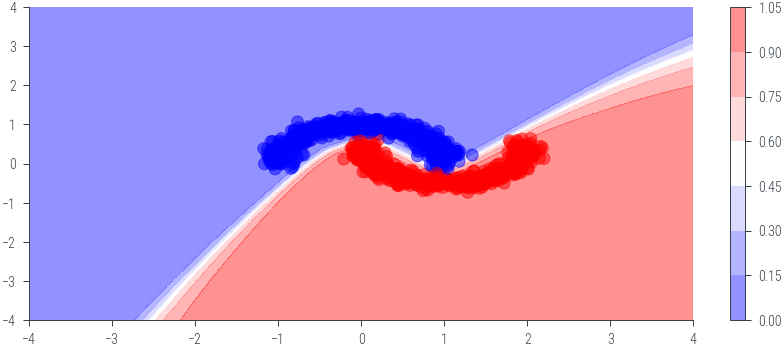

In [39]:
# Plot the posterior predictive distribution decision boundary
plt.figure()
plt.contourf(twod_grid[0].cpu().numpy(), twod_grid[1].cpu().numpy(), probs.cpu().numpy(), cmap='bwr', alpha=0.5)
plt.colorbar()
plt.scatter(x_moon[:, 0].cpu().numpy(), x_moon[:, 1].cpu().numpy(), c=y_moon.cpu().numpy(), cmap='bwr', alpha=0.5)

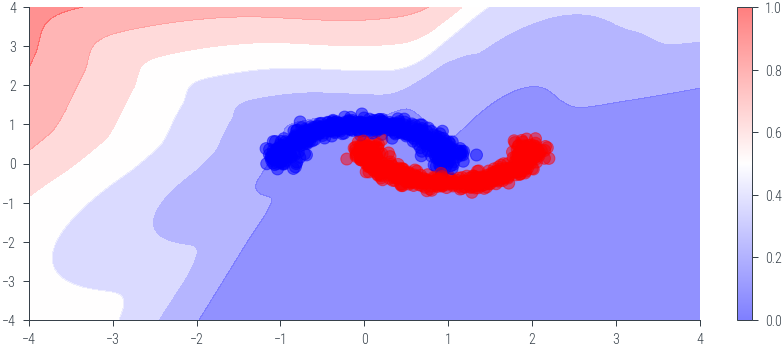

In [40]:
# Plot the variance of the posterior predictive distribution
plt.figure()
plt.contourf(twod_grid[0].cpu().numpy(), twod_grid[1].cpu().numpy(), torch.stack(y_preds).std(axis=0).reshape(n_grid, n_grid).cpu().numpy(), cmap='bwr', alpha=0.5)
plt.scatter(x_moon[:, 0].cpu().numpy(), x_moon[:, 1].cpu().numpy(), c=y_moon.cpu().numpy(), cmap='bwr', alpha=0.5)
plt.colorbar()